## Imports

In [1]:
import json
import matplotlib.pyplot as plt
import torch

import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor
import os
from torchvision.io import read_image
from PIL import Image

import numpy as np
import matplotlib.patches as patches
from torchvision import transforms

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

from torchmetrics.detection.map import MeanAveragePrecision

import pycocotools

In [2]:
# imports from local lib files
import utils
import transforms
import coco_eval
from engine import train_one_epoch, evaluate

## File paths

In [3]:
output_path = 'output'
img_folder = 'eccv_18_all_images_sm'

cis_test_ann_path = 'eccv_18_annotation_files/cis_test_annotations.json'
cis_val_ann_path = 'eccv_18_annotation_files/cis_val_annotations.json'
train_ann_path = 'eccv_18_annotation_files/train_annotations.json'
trans_test_ann_path = 'eccv_18_annotation_files/trans_test_annotations.json'
trans_val_ann_path = 'eccv_18_annotation_files/trans_val_annotations.json'

## Basic data exploration

In [4]:
cis_test_ann = json.load(open(cis_test_ann_path))
cis_val_ann = json.load(open(cis_val_ann_path))
train_ann = json.load(open(train_ann_path))
trans_test_ann = json.load(open(trans_test_ann_path))
trans_val_ann = json.load(open(trans_val_ann_path))

In [5]:
print('cis test set length:', len(cis_test_ann['images']))
print('cis val set length:', len(cis_val_ann['images']))
print('train set length:', len(train_ann['images']))
print('trans test set length:', len(trans_test_ann['images']))
print('trans val set length:', len(trans_val_ann['images']))

cis test set length: 15827
cis val set length: 3484
train set length: 13553
trans test set length: 23275
trans val set length: 1725


In [6]:
trans_test_ann.keys()

dict_keys(['info', 'categories', 'images', 'annotations'])

In [7]:
trans_test_ann['info']

{'contributor': 'Sara Beery',
 'date_created': '2018-07-03 18:34:36.573636',
 'version': 'Caltech Camera Traps - ECCV18',
 'description': 'Database of camera trap images collected from the NPS and the USGS with help from Justin Brown and Erin Boydston',
 'year': 2018}

In [8]:
trans_test_ann['categories']

[{'id': 6, 'name': 'bobcat'},
 {'id': 1, 'name': 'opossum'},
 {'id': 30, 'name': 'empty'},
 {'id': 9, 'name': 'coyote'},
 {'id': 3, 'name': 'raccoon'},
 {'id': 11, 'name': 'bird'},
 {'id': 8, 'name': 'dog'},
 {'id': 16, 'name': 'cat'},
 {'id': 5, 'name': 'squirrel'},
 {'id': 10, 'name': 'rabbit'},
 {'id': 7, 'name': 'skunk'},
 {'id': 99, 'name': 'rodent'},
 {'id': 21, 'name': 'badger'},
 {'id': 34, 'name': 'deer'},
 {'id': 33, 'name': 'car'},
 {'id': 51, 'name': 'fox'}]

In [9]:
trans_val_ann['annotations'][0]

{'image_id': '58df680b-23d2-11e8-a6a3-ec086b02610b',
 'category_id': 6,
 'bbox': [1123.7375892857142,
  787.8743750000001,
  284.6749107142857,
  244.2854464285715],
 'id': '19220'}

In [10]:
train_ann['images'][0]

{'file_name': '5a2176e7-23d2-11e8-a6a3-ec086b02610b.jpg',
 'rights_holder': 'Justin Brown',
 'height': 1494,
 'width': 2048,
 'frame_num': 2,
 'date_captured': '2011-11-29 17:28:26',
 'location': 38,
 'seq_num_frames': 3,
 'seq_id': '6f011019-5567-11e8-a650-dca9047ef277',
 'id': '5a2176e7-23d2-11e8-a6a3-ec086b02610b'}

In [11]:
trans_val_ann['images'][1]

{'file_name': '592163c4-23d2-11e8-a6a3-ec086b02610b.jpg',
 'rights_holder': 'Justin Brown',
 'height': 1494,
 'width': 2048,
 'frame_num': 3,
 'date_captured': '2012-05-07 21:51:02',
 'location': 125,
 'seq_num_frames': 3,
 'seq_id': '6f16649c-5567-11e8-bc01-dca9047ef277',
 'id': '592163c4-23d2-11e8-a6a3-ec086b02610b'}

In [12]:
train_ann['images'][2]

{'file_name': '59af966d-23d2-11e8-a6a3-ec086b02610b.jpg',
 'rights_holder': 'Justin Brown',
 'height': 1494,
 'width': 2048,
 'frame_num': 3,
 'date_captured': '2011-12-15 09:50:03',
 'location': 43,
 'seq_num_frames': 3,
 'seq_id': '6f0be74a-5567-11e8-8662-dca9047ef277',
 'id': '59af966d-23d2-11e8-a6a3-ec086b02610b'}

In [13]:
cis_test_ann['images'][0]

{'file_name': '59b93afb-23d2-11e8-a6a3-ec086b02610b.jpg',
 'rights_holder': 'Justin Brown',
 'height': 1494,
 'width': 2048,
 'frame_num': 2,
 'date_captured': '2012-05-09 07:33:45',
 'location': 38,
 'seq_num_frames': 3,
 'seq_id': '6f04895c-5567-11e8-a3d6-dca9047ef277',
 'id': '59b93afb-23d2-11e8-a6a3-ec086b02610b'}

In [14]:
cis_test_ann['images'][1]

{'file_name': '59641f56-23d2-11e8-a6a3-ec086b02610b.jpg',
 'rights_holder': 'Justin Brown',
 'height': 1494,
 'width': 2048,
 'frame_num': 2,
 'date_captured': '2012-03-29 02:34:13',
 'location': 38,
 'seq_num_frames': 3,
 'seq_id': '6f0385b5-5567-11e8-a80b-dca9047ef277',
 'id': '59641f56-23d2-11e8-a6a3-ec086b02610b'}

## Horizontal flip debugging

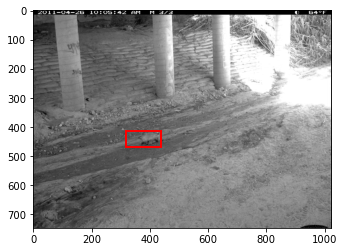

In [16]:
i = 59

boxes = [trans_val_ann['annotations'][j]['bbox'] for j in range(len(trans_val_ann['annotations'])) 
         if trans_val_ann['annotations'][j]['image_id']==trans_val_ann['images'][i]['id'] 
         and 'bbox' in trans_val_ann['annotations'][j].keys()]

img_path = os.path.join('eccv_18_all_images_sm', trans_val_ann['images'][i]['file_name']) # to change

image = read_image(img_path)

fig, ax = plt.subplots()
ax.imshow(image[0].squeeze(), cmap='gray')

scale_x = image.shape[2] / trans_val_ann['images'][i]['width'] 
scale_y = image.shape[1] / trans_val_ann['images'][i]['height']

boxes = torch.as_tensor(boxes)

for i in range(boxes.shape[0]):
    boxes[i][0] = torch.round(boxes[i][0] * scale_x)
    boxes[i][1] = torch.round(boxes[i][1] * scale_y)
    boxes[i][2] = torch.round(boxes[i][2] * scale_x)
    boxes[i][3] = torch.round(boxes[i][3] * scale_y)

    boxes[i][2] = boxes[i][0] + boxes[i][2]
    boxes[i][3] = boxes[i][1] + boxes[i][3]

target = {}
target["boxes"] = boxes

rect = patches.Rectangle((boxes[0][0], boxes[0][1]), boxes[0][2]-boxes[0][0], 
                         boxes[0][3]-boxes[0][1], linewidth=2, edgecolor='r', facecolor='none')
ax.add_patch(rect)

In [51]:
img_path

'eccv_18_all_images_sm\\59180ad1-23d2-11e8-a6a3-ec086b02610b.jpg'

In [52]:
image2 = Image.open(img_path).convert("RGB")

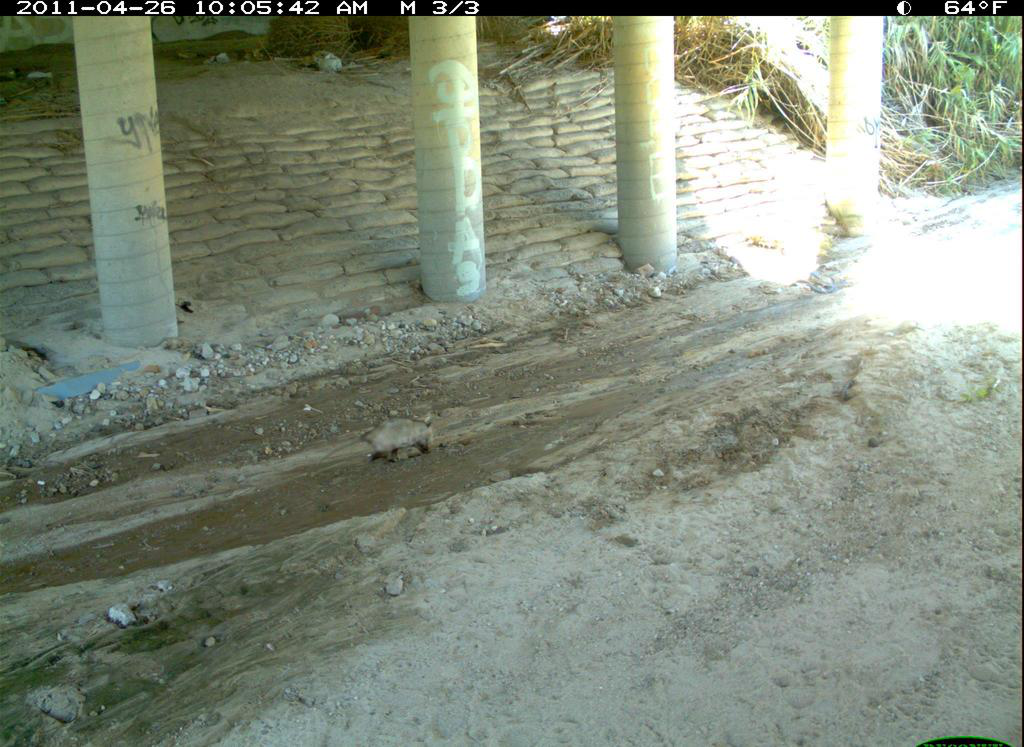

In [53]:
image2

In [24]:
image2.size

(1024, 747)

In [ ]:
conv = torchvision.transforms.ToTensor()

In [ ]:
width, height = image2.size[0], image2.size[1]

In [ ]:
print('width:', width)
print('height:', height)

In [ ]:
image_new = conv(image2)

In [ ]:
print('image_new.shape:', image_new.shape)

## Utils part

In [ ]:
# In paper :  ' ... and employ horizontal flipping for data augmentation. ( for detection)

import transforms as T   # from local files (from github repo)

data_transform = {'train': T.RandomHorizontalFlip(0.5)}

In [ ]:
# Returns a list with the idx of images with at least one bounding box (img_wbbox) and a 
# list with the number of bbox for each valid image (num_bbox)
def get_img_with_bbox(file_path):
  
    file = json.load(open(file_path))
    img_wbbox = []
    num_bbox = []

    for i in range(len(file['images'])):
        bboxes = [file['annotations'][j]['bbox'] 
                  for j in range(len(file['annotations'])) 
                  if file['annotations'][j]['image_id']==file['images'][i]['id'] 
                  and 'bbox' in file['annotations'][j].keys()]

        if len(bboxes)!=0:
            img_wbbox.append(i)

            num_bbox.append(len(bboxes))

    return img_wbbox, num_bbox

In [ ]:
class CustomImageDataset(Dataset):
    def __init__(self, label_path, img_dir, valid_img, transform = None, target_transform=None):
        self.label_file = json.load(open(label_path))
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform
        self.valid_img = valid_img

    def __len__(self):
        return len(self.valid_img)

    def __getitem__(self, idx):
        
        idx = self.valid_img[idx] # consider only images with bbox annotations
        img_path = os.path.join(self.img_dir, self.label_file['images'][idx]['file_name'])
        image = read_image(img_path)

        conv = torchvision.transforms.ToTensor()
        # if image.shape[0]==1:
        # some images have only one channel, we convert them to rgb
        image = Image.open(img_path).convert("RGB")
        image = conv(image)

        boxes = [self.label_file['annotations'][j]['bbox'] 
                 for j in range(len(self.label_file['annotations'])) 
                 if self.label_file['annotations'][j]['image_id']==self.label_file['images'][idx]['id']]
        
        label = [self.label_file['annotations'][j]['category_id'] 
                 for j in range(len(self.label_file['annotations'])) 
                 if self.label_file['annotations'][j]['image_id']==self.label_file['images'][idx]['id']]

        # transform bbox coords to adjust for resizing
        scale_x = image.shape[2] / self.label_file['images'][idx]['width'] 
        scale_y = image.shape[1] / self.label_file['images'][idx]['height']

        boxes = torch.as_tensor(boxes)
        for i in range(boxes.shape[0]):
            boxes[i][0] = torch.round(boxes[i][0] * scale_x)
            boxes[i][1] = torch.round(boxes[i][1] * scale_y)
            boxes[i][2] = torch.round(boxes[i][2] * scale_x)
            boxes[i][3] = torch.round(boxes[i][3] * scale_y)

            boxes[i][2] = boxes[i][0] + boxes[i][2] # to transform to pytorch bbox format
            boxes[i][3] = boxes[i][1] + boxes[i][3]

            #boxes[i][0]*=scale_x
            #boxes[i][1]*=scale_y
            #boxes[i][2]*=scale_x
            #boxes[i][3]*=scale_y

        label=torch.as_tensor(label)
        label=torch.where(label==30,0,1)  # 0 if empty (categ id = 30), 1 if animal
        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        iscrowd = torch.zeros((boxes.shape[0],), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = label
        target["image_id"] = image_id
        target['area']=area
        target['iscrowd']=iscrowd

        # TO DO : resize all to same size

        if self.transform:
            # transform image AND target
            image, target = self.transform(image, target)
        if self.target_transform:
            label = self.target_transform(label)

        return image, target

## Exemple of use

In [ ]:
# get the images bounding boxes *takes about 25sec*
train_valid_img,_ = get_img_with_bbox(train_ann_path)
cis_val_valid_img,_ = get_img_with_bbox(cis_val_ann_path)

In [ ]:
training_data = CustomImageDataset(train_ann_path, img_folder, train_valid_img)
valid_data = CustomImageDataset(cis_val_ann_path, img_folder, cis_val_valid_img)

train_dataloader = DataLoader(training_data, batch_size=1, shuffle=True, collate_fn=utils.collate_fn)

# In paper : ' We use a batch size of 1'

In [ ]:
train_features, train_labels = next(iter(train_dataloader))
#print(f"Feature batch shape: {train_features.size()}")
print(f"Target (Bbox) batch shape: {train_labels[0]['boxes'].size()}")
print(f"Target (category) batch shape: {train_labels[0]['labels'].size()}")

img = train_features[0][0].squeeze()
label = train_labels[0]['labels']
label_categ='animal'

if label[0]==0:
    label_categ='background'

fig, ax = plt.subplots()
ax.imshow(img,cmap="gray")
rect = patches.Rectangle((train_labels[0]['boxes'][0][0], train_labels[0]['boxes'][0][1]), train_labels[0]['boxes'][0][2]-train_labels[0]['boxes'][0][0], train_labels[0]['boxes'][0][3]-train_labels[0]['boxes'][0][1], linewidth=2, edgecolor='r', facecolor='none')
ax.add_patch(rect)
print(f"Label: {label_categ}")

In [ ]:
trans = data_transform['train']
img2, target2 = trans(image, target)

fig, ax = plt.subplots()
ax.imshow(img2, cmap="gray")

rect = patches.Rectangle((target2['boxes'][0][0], target2['boxes'][0][1]), 
                         target2['boxes'][0][2] - target2['boxes'][0][0], 
                         target2['boxes'][0][3] - target2['boxes'][0][1], 
                         linewidth=2, edgecolor='r', facecolor='none')
ax.add_patch(rect)

### Plots

In [ ]:
# Imported logs - format: name = "NAME_OR_TIME"      Exemple file format: "NAME_OR_TIME_train_logs"

file_time_or_nickname = '25_roi' # VALUE TO CHANGE TO THE IMPORTED FILES

# Import training logs
with open('saved_logs/' + file_time_or_nickname + '_train_logs.json', "r") as f:
    train_logs = train_logs + json.load(f)

# Import cis valid logs
with open('saved_logs/' + file_time_or_nickname + '_cis_valid_logs.json', "r") as f:
    cis_valid_logs = cis_valid_logs + json.load(f)

# Import trans valid logs
with open('saved_logs/' + file_time_or_nickname + '_trans_valid_logs.json', "r") as f:
    trans_valid_logs = trans_valid_logs + json.load(f)

In [ ]:
# Imported logs - format: name = "NAME_OR_TIME"      Exemple file format: "NAME_OR_TIME_train_logs"

file_time_or_nickname = '10_roi' # VALUE TO CHANGE TO THE IMPORTED FILES

# Import training logs
with open('saved_logs/' + file_time_or_nickname + '_train_logs.json', "r") as f:
    train_logs = json.load(f)

# Import cis valid logs
with open('saved_logs/' + file_time_or_nickname + '_cis_valid_logs.json', "r") as f:
    cis_valid_logs = json.load(f)

# Import trans valid logs
with open('saved_logs/' + file_time_or_nickname + '_trans_valid_logs.json', "r") as f:
    trans_valid_logs = json.load(f)

In [ ]:
train_logs = train_logs_to_lst(last_train_logs)
cis_valid_logs = valid_logs_to_lst(last_cis_valid_logs)
trans_valid_logs = valid_logs_to_lst(last_trans_valid_logs)

In [ ]:
# To confirm that the data is loaded properly
len(train_logs)

In [ ]:
# Train loss to print (here we use global_avg but we can use: value, median, avg, max or global_avg)
results_train_loss = []

for i in range(num_epochs):
    results_train_loss.append(train_logs[i]['loss_box_reg']['global_avg'])

In [ ]:
# Cis valid loss to print
results_cis_valid_loss = [] # cis

for i in range(num_epochs):
    loss_interm = 0
    for j in range(167):
        loss_interm += cis_valid_logs[(167 * i) + j]['loss_box_reg']
    results_cis_valid_loss.append(loss_interm)